<a href="https://colab.research.google.com/github/Mintas/diving-deep-learning/blob/master/Test_learning_for_different_batch_sizes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls
#%cd diving-deep-learning/
!git clone https://github.com/Mintas/diving-deep-learning.git
#!git checkout origin/master
#!git fetch
#!git pull

sample_data
Cloning into 'diving-deep-learning'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (251/251), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 251 (delta 145), reused 185 (delta 86), pack-reused 0
Receiving objects: 100% (251/251), 4.98 MiB | 8.08 MiB/s, done.
Resolving deltas: 100% (145/145), done.


In [0]:
!cat /proc/meminfo

In [0]:
!cat /proc/cpuinfo

In [2]:
!ls
%cd diving-deep-learning/

diving-deep-learning  sample_data
/content/diving-deep-learning


In [0]:
from __future__ import print_function
# %matplotlib inline
import random
import torch
import torch.nn as nn
import torch.utils.data

import domain.ecaldata
import domain.parameters

import training.losses
import training.optimDecorators
from plots import painters, plotUi
import mygan
import architectures.dcganReSize8 as myzoo#dcganBatchNorm as myzoo
from training import trainer
import numpy as np
from serialization import iogan

from analytics import analytic_funcs as AF
from analytics import optimized_analytic_funcs as OAF
from os.path import dirname
import matplotlib.pyplot as plt
from timeit import default_timer as timer




In [4]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
device

device(type='cuda', index=0)

In [5]:
from google.colab import drive
drive.mount('/ecal')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /ecal


In [6]:
%cd /
%cd ecal/My Drive/ecal

# dataSet = myfuncs.ProbDistrDataset(torch.distributions.normal.Normal(0,1), 128000)
datasetName = 'caloGAN_v3_case2_50K'
ecalData = np.load('%s.npz' % datasetName)

/
/ecal/My Drive/ecal


In [20]:
%cd /
%cd content/diving-deep-learning/
%mkdir resources/computed

archVersion = 'dcganBatchNorm_resize8_LIN' #arch version
resultingName = 'resources/computed/%s_%s' % (datasetName, archVersion)

/
/content/diving-deep-learning
mkdir: cannot create directory ‘resources/computed’: File exists


In [8]:
# Set fixed random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


Random Seed:  999


In [28]:

nc = 1  # we got 1channel response
nz = 100 # latent space size | 42 is close to hypotenuse of response 30x30
imgSize = 8  # our respons is 30x30
ngf = 30  # todo : decide Generator feature-space characteristic size
#ndf = 30  # decide Critic feature-space characteristic size
lr = 0.00015  # Learning rate for optimizers | 0.04 is good for SGD and 0.0001 for RMSProp
beta1 = 0.5  # Beta1 hyperparam for Adam optimizers
ngpu = 1 if device else 0  # increase for GPU hosted calculations
gpWeight = 0.5 # gradient penalty weight; somehow 0.1 is nice, 1 is so so, 10 is bad, 0.01 is vanishing
type = mygan.GANS.WGAN # we are going to try gan, wgan-gp and cramerGan
initOptimizer = training.optimDecorators.optRMSProp  # works almost as well for SGD and lr = 0.03

hyperParams = domain.parameters.HyperParameters(ngpu, lr, beta1)
# Decide which device we want to run on
if device is None: device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")



def initNet(netClass, hp, prblm, dvc):
    net = netClass(type, hp, prblm).to(dvc)
    # Handle multi-gpu if desired
    if (device.type == 'cuda') and (ngpu > 1):
        net = nn.DataParallel(net, list(range(ngpu)))
    net.apply(mygan.weights_init)
    #print(net)  # Print the model
    return net
  
problem = domain.parameters.ProblemSize(nz, ngf, nc, 1000, imgSize)
                                         
netG = initNet(GenEcal, hyperParams, problem, device)
netD = initNet(DiscEcal, hyperParams, problem, device)
print(netG)
print(netD)
                 

GenEcal(
  (main): Sequential(
    (0): Linear(in_features=100, out_features=130, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(130, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=130, out_features=260, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(260, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=260, out_features=520, bias=True)
    (7): Tanh()
    (8): BatchNorm1d(520, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=520, out_features=64, bias=True)
    (10): ReLU()
  )
)
DiscEcal(
  (main): Sequential(
    (0): Linear(in_features=64, out_features=520, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=520, out_features=260, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=260, out_features=130, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=130, out_features=1

In [29]:
ecalDataPojo = domain.ecaldata.dictToEcalData(ecalData)
if imgSize != 30:
  ecalDataPojo = domain.ecaldata.resizeResponses(ecalDataPojo, imgSize)
dataSet = torch.utils.data.TensorDataset(torch.from_numpy(ecalDataPojo.response).float())

print(ecalDataPojo.response.shape)
print(ecalData['EnergyDeposit'].shape)

(50000, 8, 8)
(50000, 30, 30)


HERE WE WILL DEFINE OUR TESTPLAN !!!


In [0]:
tds = len(dataSet)
#gonna train 50k dataset with batch_sizes of 50, 100, 250, 500, 1000, 2500, 5000, 10k, measured in % in testCases below
#NOTE !!! I decided to train nets for 200 epochs only, because of to slow learning process 
# [tds * 0.2, 200], [tds * 0.1, 200], , [tds * 0.002, 10], [tds * 0.005, 20], [tds * 0.02, 100],  [tds * 0.05, 100]
testPlan = [ [tds * 0.02, 200] ]# [tds * 0.001, 10],  [tds * 0.01, 25], [tds * 0.1, 50] ]
#testPlan = [ [tds * 0.2, 250]  ]

In [0]:
import os
gpWeight = 0.5 # gradient penalty weight; somehow 0.1 is nice, 1 is so so, 10 is bad, 0.01 is vanishing


for testCase in testPlan :
  print()
  batch_size = int(testCase[0])  # Batch size during training
  num_epochs = testCase[1]  # 5 for example, need much more for learning
  ganFile = resultingName 
  print(ganFile + ' is found?     ' + str(os.path.isfile(ganFile)))
  pdfFile = resultingName + '_' + str(batch_size)
  itersPerEpoch = len(dataSet) / batch_size
  print(pdfFile + '\t' + str(itersPerEpoch))
  debugg = trainer.Debugg(itersPerEpoch / 5, itersPerEpoch, min(num_epochs, 20)) #plot set to big number to force trainer to plot generated images only once per epoch
  

  problem = domain.parameters.ProblemSize(nz, ngf, nc, batch_size, imgSize)
                                        
  dataLoader = torch.utils.data.DataLoader(dataSet, batch_size=batch_size, shuffle=True, num_workers=1)

  lossCalculator = training.losses.GanLoss(device, problem, nn.BCELoss()) if type == mygan.GANS.GAN \
        else (training.losses.WganLoss if type == mygan.GANS.WGAN else training.losses.CramerEneryGanLoss)(problem,
                                                                                                           training.losses.GradientPenalizer(gpWeight,True,ngpu > 0))
  #training phase
  netG.train(), netD.train()
  ganTrainer = trainer.Trainer(device, problem, lossCalculator, initOptimizer, lambda d: d[0], ganFile, debugg)

  ui = plotUi.PDFPlotUi(pdfFile)
  painter = painters.ECalPainter(ui)
  print("Starting Training Loop...")
  start = timer()
  dopt, gopt = ganTrainer.train(netD, netG, dataLoader, num_epochs, hyperParams, painter, 8)
    # painter.plotFake(netG.forward(torch.randn(128000, nz, 1, 1, device=device)), num_epochs, 0)
  end = timer()
  print('!!!!!!!!!!!!!!!!!! TIME ELAPSED : ' + str(end - start))
  
  ui.toView(lambda: painters.plotLosses(ganTrainer.G_losses, ganTrainer.D_losses))
  latest = min(num_epochs, 5000)
  ui.toView(lambda: painters.plotLosses(ganTrainer.G_losses[-latest:], ganTrainer.D_losses[-latest:]))
  if type != mygan.GANS.GAN:
      ui.toView(lambda: painters.plotGradPenalties(ganTrainer.ganLoss.gradientPenalizer.penalties, ganTrainer.ganLoss.gradientPenalizer.norms))

  ui.close()
  
                                                                                                                                                                                                                     
  #evaluation phase
  netG.eval(), netD.eval()
    
  shape = ecalDataPojo.response.shape
  print(shape)

  with torch.no_grad():
    tonnsOfNoise = torch.randn(shape[0], nz, 1, 1, device=device)
    generated = netG(tonnsOfNoise)
    fakeData = domain.ecaldata.EcalData(generated.reshape(shape).cpu().numpy(), ecalDataPojo.momentum, ecalDataPojo.point)

  OAF.runAnalytics('/' + pdfFile, ecalDataPojo, fakeData)

  plt.imshow(abs(np.mean(ecalDataPojo.response, axis=0, keepdims=False) - np.mean(fakeData.response, axis=0, keepdims=False)))  
  plt.colorbar()
  plt.show()
  
  #finally we want to save our results to mounted GoogleDrive
  #%cp -v $ganFile*  '/ecal/My Drive/ecal/testIncreaseBatchSizeX10'
                                                                                                            
                                                                                                              
  
  




resources/computed/caloGAN_v3_case2_50K_dcganBatchNorm_resize4_BN is found?     False
resources/computed/caloGAN_v3_case2_50K_dcganBatchNorm_resize4_BN_1000	50.0
Starting Training Loop...
loaded precomputed gans
[200/200][0/50]	Loss_D: 0.2261	Loss_G: -0.4099	D(x): 0.6119	D(G(z)): 0.8296 / 0.4099
[200/200][10/50]	Loss_D: 0.0968	Loss_G: -1.5386	D(x): 1.0189	D(G(z)): 1.1070 / 1.5386
[200/200][20/50]	Loss_D: -0.0731	Loss_G: -2.4419	D(x): 3.0577	D(G(z)): 2.9752 / 2.4419
[200/200][30/50]	Loss_D: -0.0731	Loss_G: -1.8038	D(x): 2.2534	D(G(z)): 2.1749 / 1.8038
[200/200][40/50]	Loss_D: 0.0460	Loss_G: -1.0757	D(x): 1.0079	D(G(z)): 1.0511 / 1.0757
!!!!!! SAVING MODELS DONT BREAK EXECUTION !!!!!!
!!!!!! Models have been saved successfully !!!!!
[201/200][0/50]	Loss_D: 0.1844	Loss_G: -0.2917	D(x): 0.4674	D(G(z)): 0.6321 / 0.2917
[201/200][10/50]	Loss_D: -0.1360	Loss_G: 3.9410	D(x): -2.6665	D(G(z)): -2.8115 / -3.9410
[201/200][20/50]	Loss_D: -0.0000	Loss_G: 3.0169	D(x): -2.8072	D(G(z)): -2.8220 / -3.

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


[219/200][10/50]	Loss_D: 0.1671	Loss_G: 3.2189	D(x): -3.2633	D(G(z)): -3.1120 / -3.2189


EnergyDeposit  shape: (50000, 30, 30)
 min: 0.0	 max: 120.51937607980491
 first particle Momentum :  [0.15657315 0.14722511 2.4455745 ]
 Point :[ -1.00722767  -0.96538278 -19.8       ]
 particle type is : 22


/content/diving-deep-learning/analytics/plotAnalytics.py:21: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img) if logScale else img, interpolation='nearest')


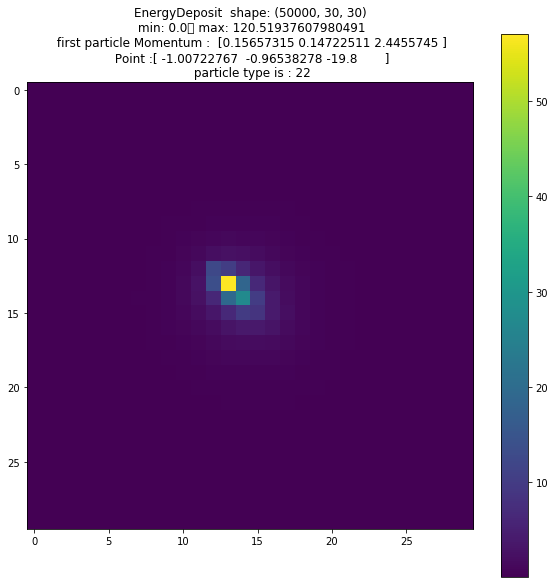

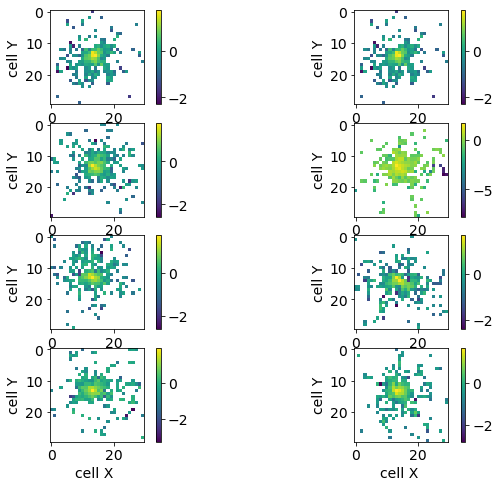

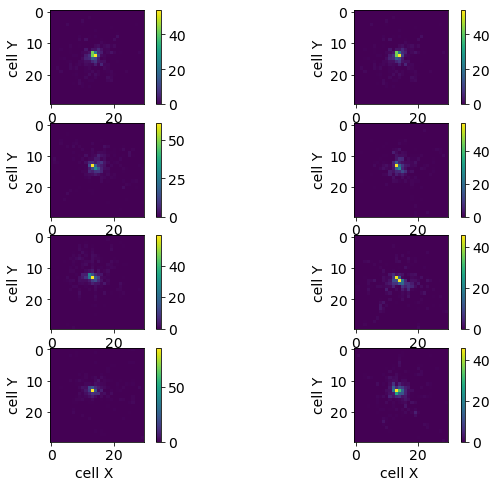

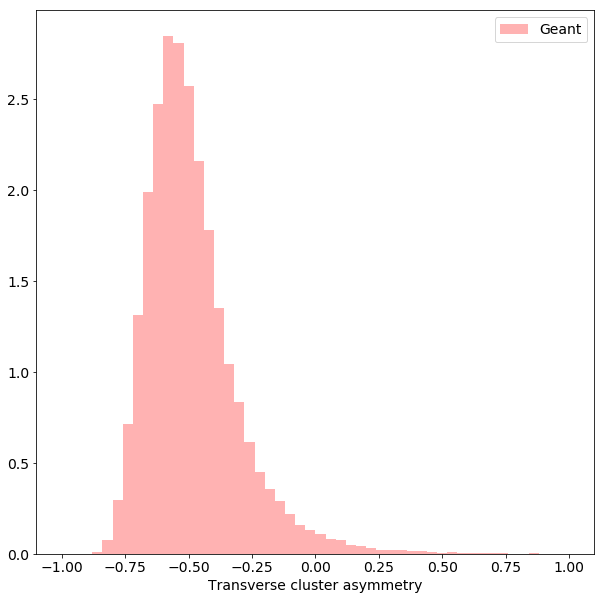

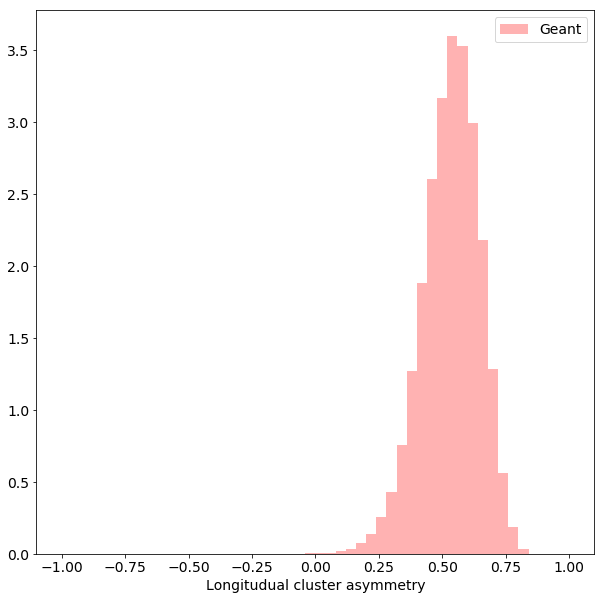

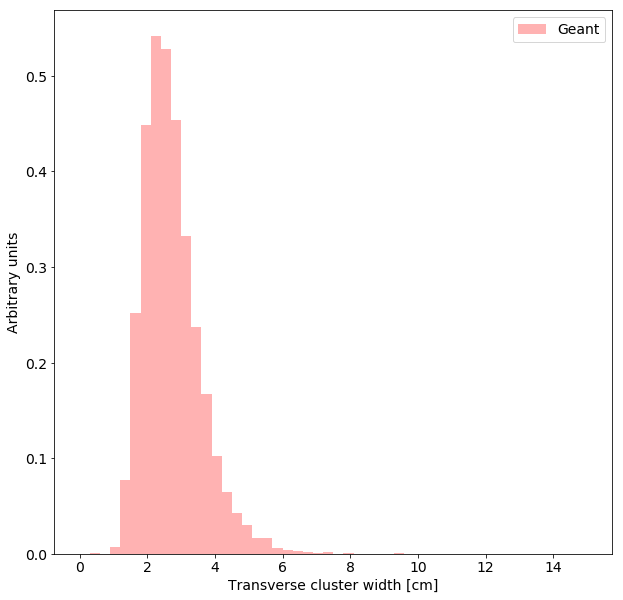

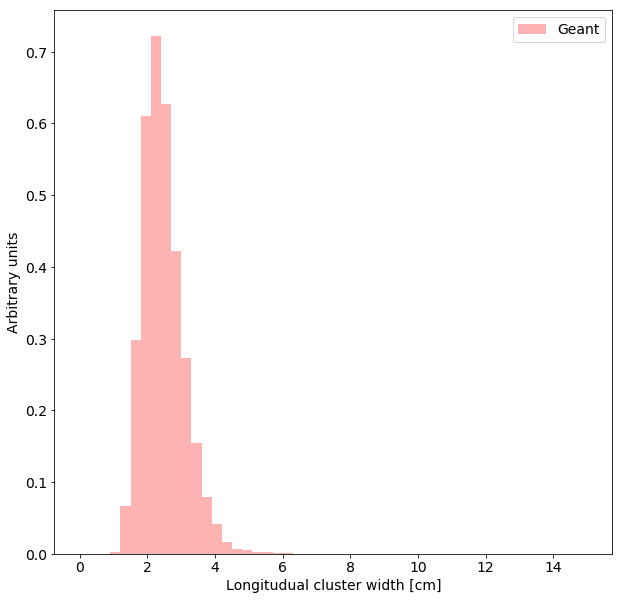

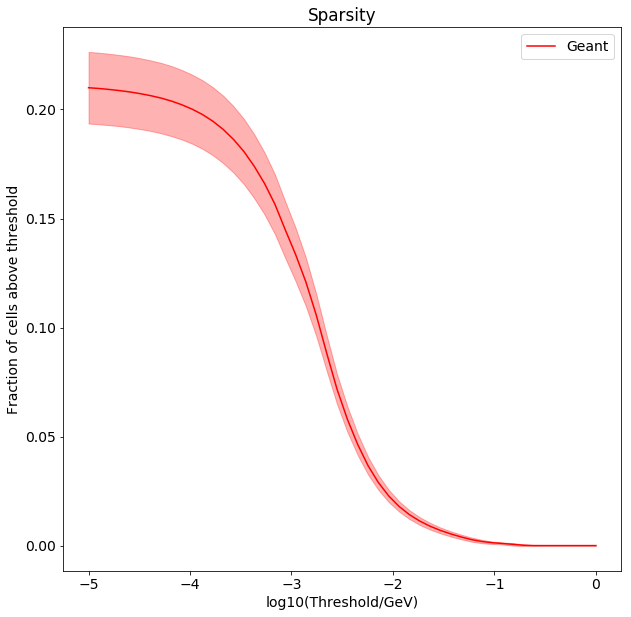

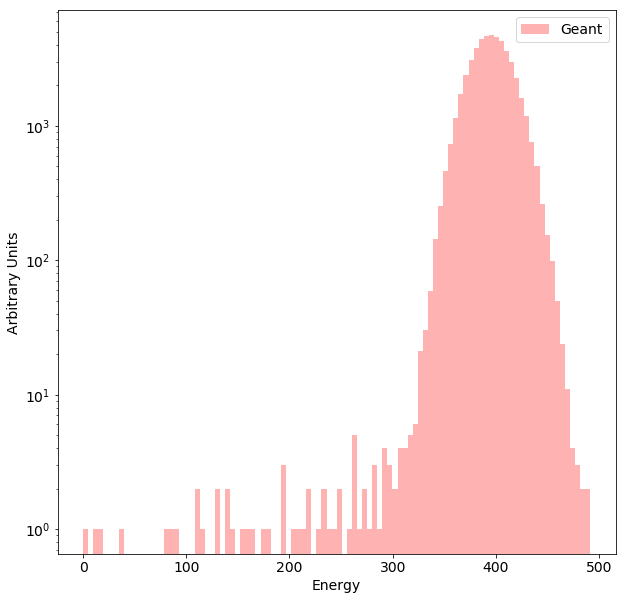

In [0]:
from analytics import optimized_analytic_funcs as OAF

ecalAnalized = OAF.runAnalytics(datasetName, ecalDataPojo, None)
#OAF.runAnalytics(datasetName, ecalDataPojo, None, ecalAnalized)
torch.save(ecalAnalized, resultingName + '_analytic' + iogan.EXTENSION)

In [0]:
resized = OAF.runAnalytics(datasetName, domain.ecaldata.resizeResponses(ecalDataPojo, 8), None)
#OAF.runAnalytics(datasetName, ecalDataPojo, None, ecalAnalized)
#torch.save(ecalAnalized, resultingName + '_analytic' + iogan.EXTENSION)

In [0]:
def plotLosses(G_losses, D_losses):
    plt.figure()
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses, label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()

def plotGradPenalties(penalties, norms):
    plt.figure()
    plt.title("Gradient Penalties and Norms During Training")
    plt.plot(penalties, label="P")
    plt.plot(norms, label="N")
    plt.xlabel("iterations")
    plt.ylabel("Value")
    plt.legend()

(50000, 8, 8)
EnergyDeposit  shape: (50000, 30, 30)
 min: 0.0	 max: 120.51937607980491
 first particle Momentum :  [0.15657315 0.14722511 2.4455745 ]
 Point :[ -1.00722767  -0.96538278 -19.8       ]
 particle type is : 22
 Resized to 8x8



/content/diving-deep-learning/analytics/plotAnalytics.py:21: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img) if logScale else img, interpolation='nearest')
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:857: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  self.axes.set_ylim((ymin, ymax), auto=None)


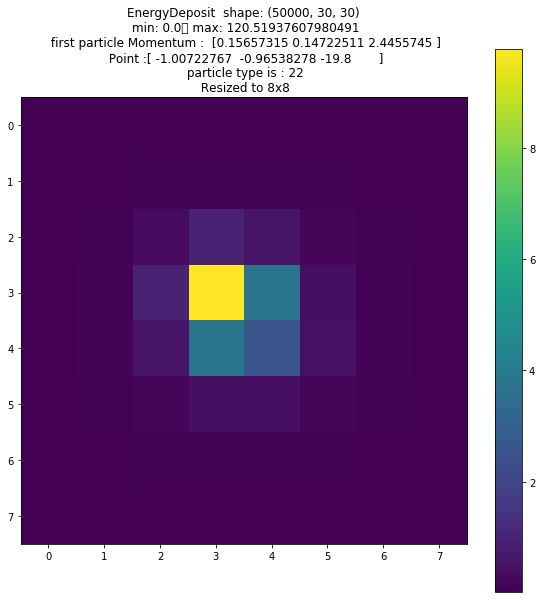

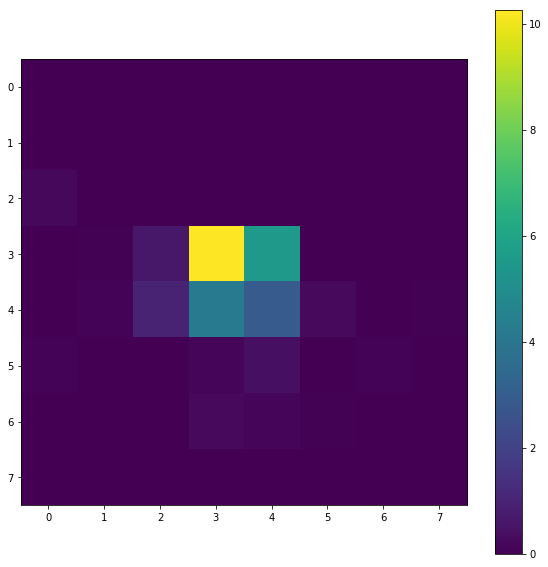

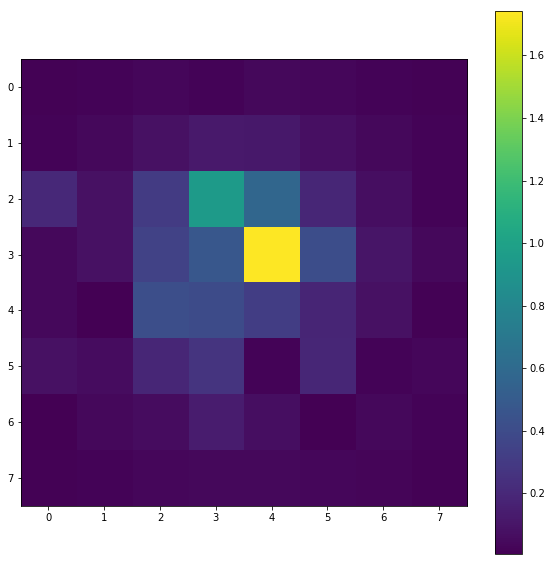

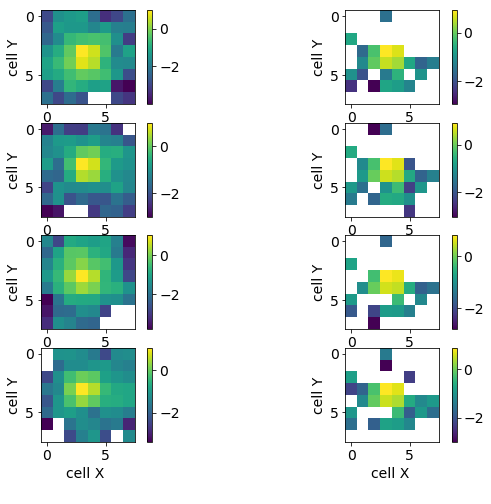

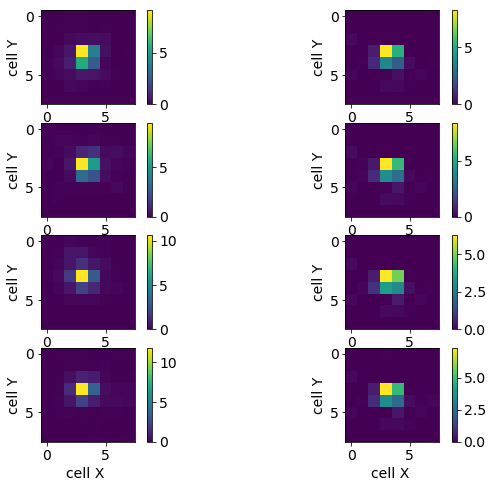

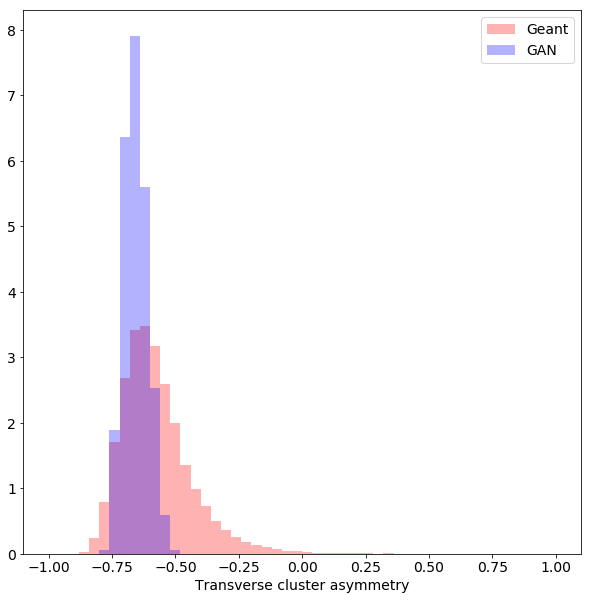

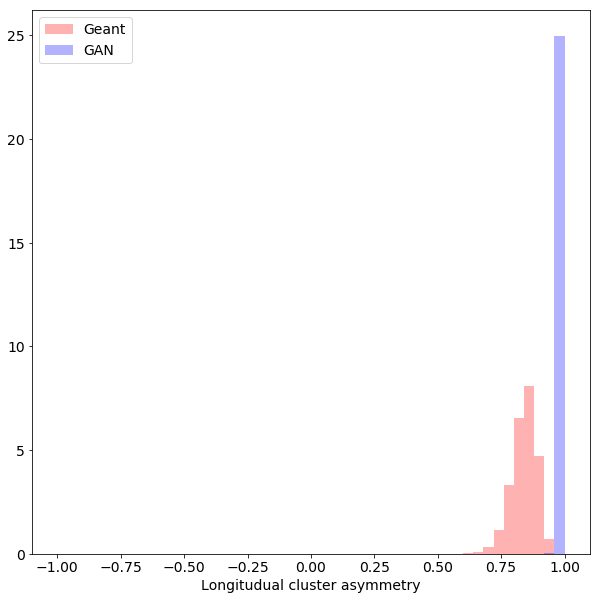

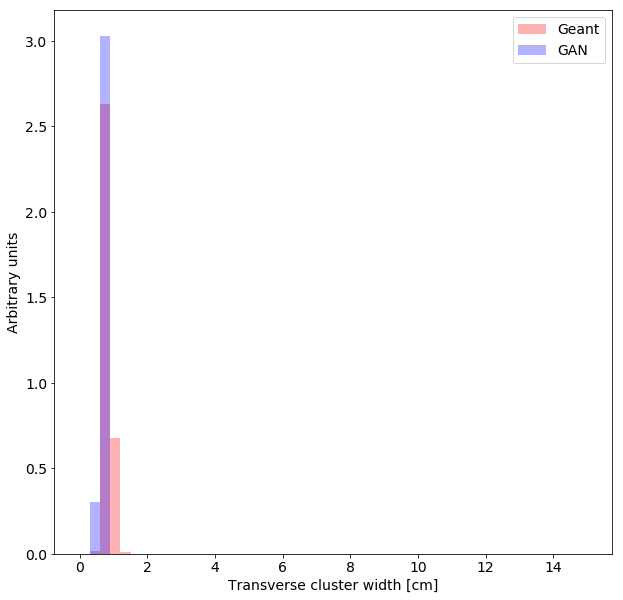

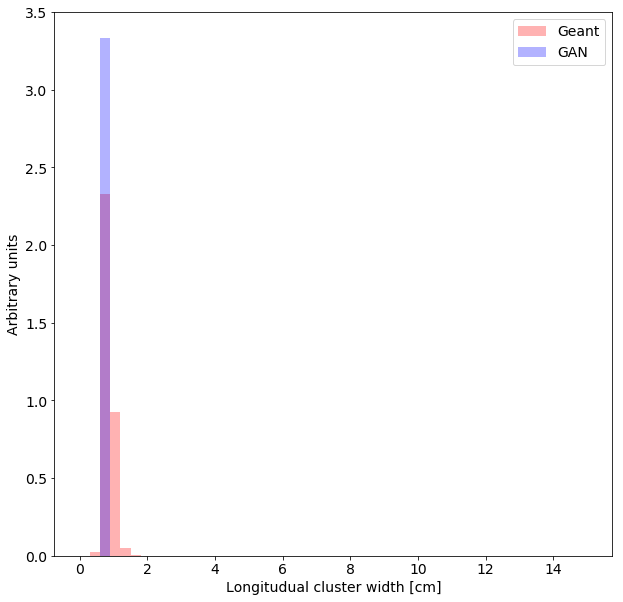

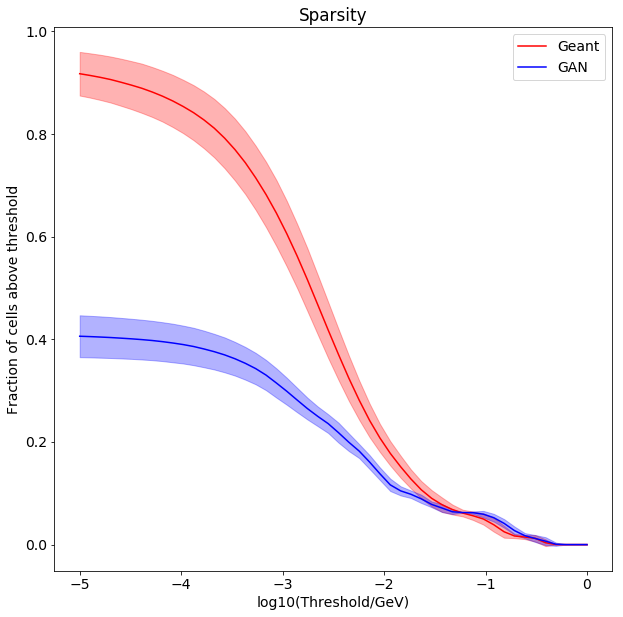

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:2575: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  self.apply_aspect()
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:4371: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  self.apply_aspect()
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:848: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  self.apply_aspect()


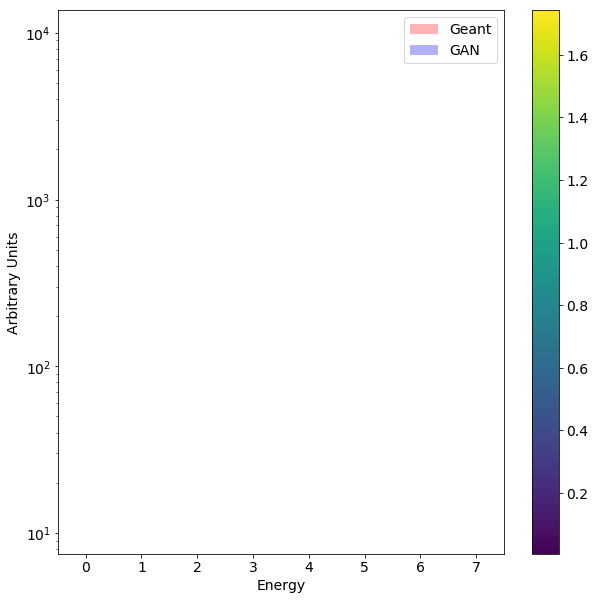

In [17]:
checkpoint = torch.load(resultingName + iogan.EXTENSION)

netD.load_state_dict(checkpoint['D_state'])
netG.load_state_dict(checkpoint['G_state'])
netG.eval(), netD.eval()

#%cd /
#%cd content/
#ecalData = AF.parseEcalData(datasetName)

#%cd /
#%cd content/diving-deep-learning/
    
    
shape = ecalDataPojo.response.shape
print(shape)

with torch.no_grad():
  tonnsOfNoise = torch.randn(shape[0], nz, 1, 1, device=device)
  generated = netG(tonnsOfNoise)
  fakeData = domain.ecaldata.EcalData(generated.reshape(shape).cpu().numpy(), ecalDataPojo.momentum, ecalDataPojo.point)

OAF.runAnalytics('/' + resultingName, ecalDataPojo, fakeData)

plt.imshow(abs(np.mean(ecalDataPojo.response, axis=0, keepdims=False) - np.mean(fakeData.response, axis=0, keepdims=False)))  
plt.colorbar()
plt.show()  


In [0]:
ganFile = resultingName
checkpoint = torch.load(ganFile + '.pth.pth')
checkpoint.keys()

dict_keys(['fixedNoise', 'D_state', 'G_state', 'Dopt', 'Gopt', 'epoch', 'DLoss', 'GLoss'])

(50000, 8, 8)
EnergyDeposit  shape: (50000, 30, 30)
 min: 0.0	 max: 120.51937607980491
 first particle Momentum :  [0.15657315 0.14722511 2.4455745 ]
 Point :[ -1.00722767  -0.96538278 -19.8       ]
 particle type is : 22
 Resized to 8x8



/content/diving-deep-learning/analytics/plotAnalytics.py:21: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img) if logScale else img, interpolation='nearest')
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages

ValueError: ignored

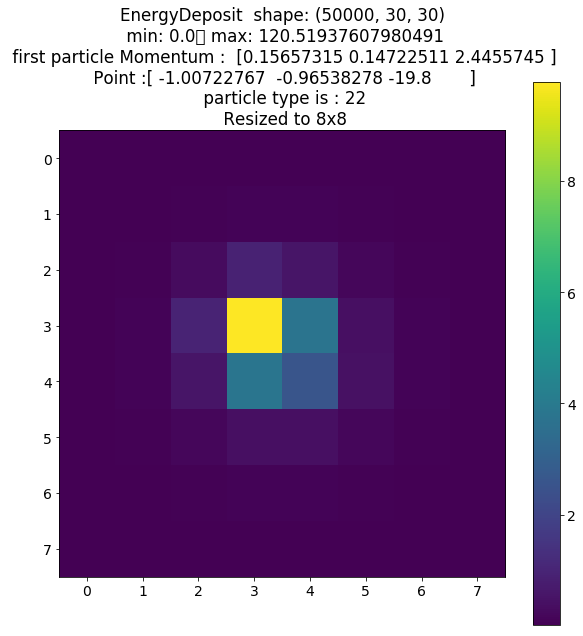

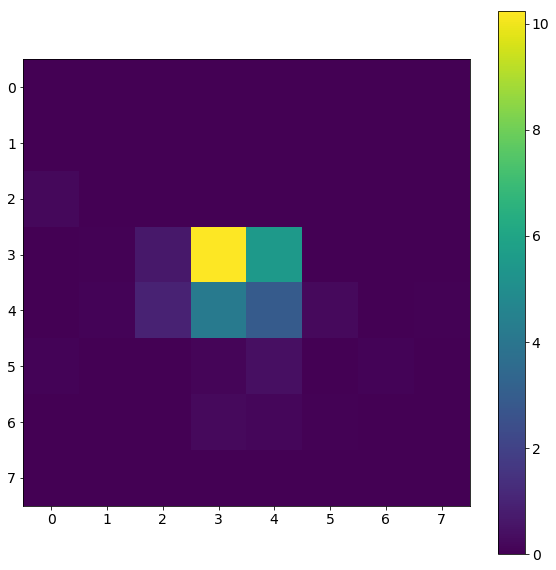

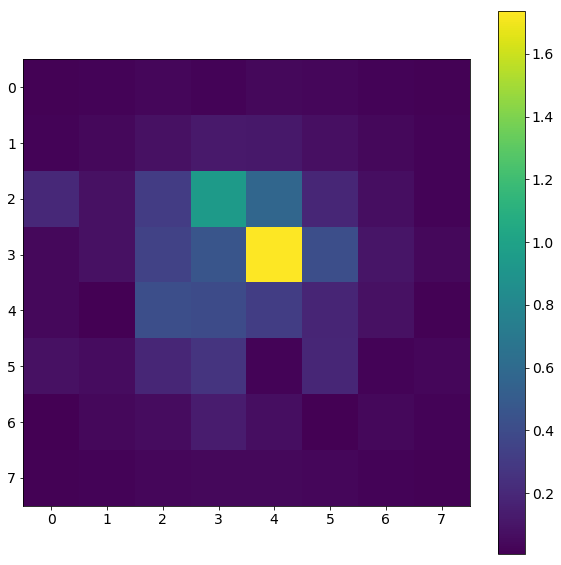

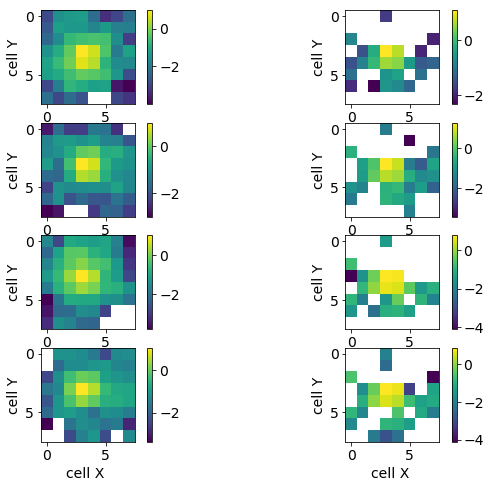

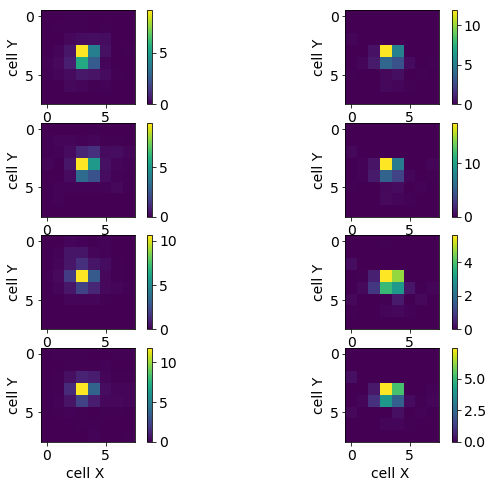

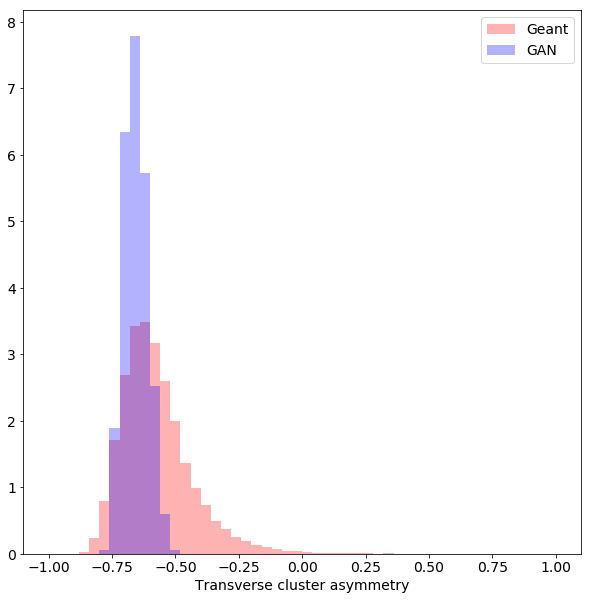

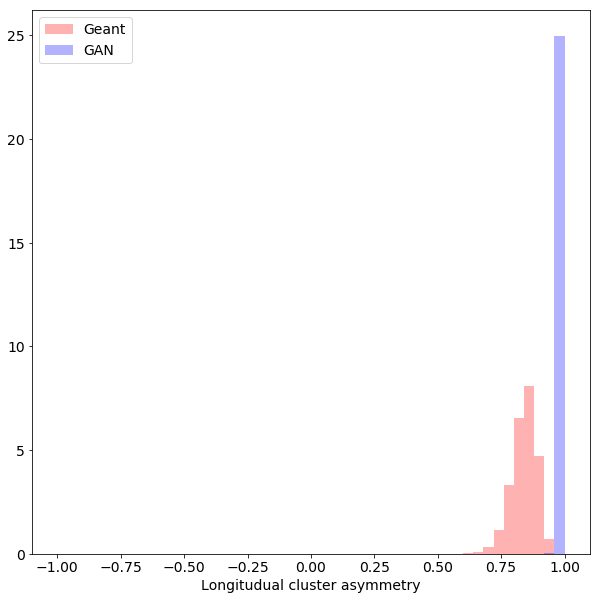

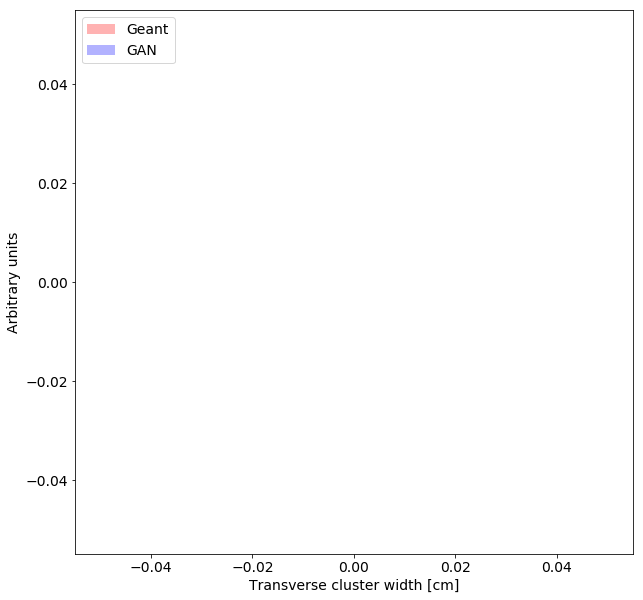

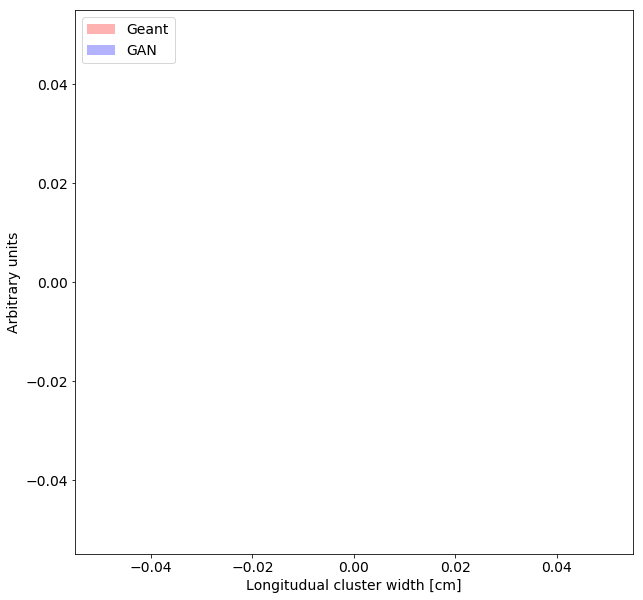

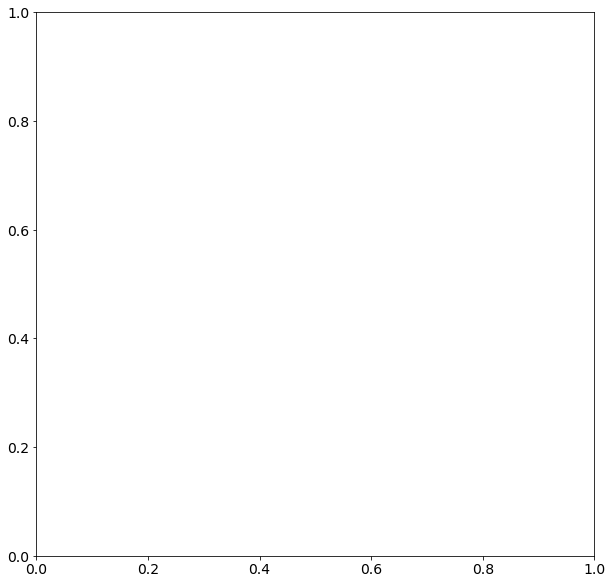

In [15]:
  #evaluation phase
  netG.eval(), netD.eval()
    
  shape = ecalDataPojo.response.shape
  print(shape)

  with torch.no_grad():
    tonnsOfNoise = torch.randn(shape[0], nz, 1, 1, device=device)
    generated = netG(tonnsOfNoise)
    fakeData = domain.ecaldata.EcalData(generated.reshape(shape).cpu().numpy(), ecalDataPojo.momentum, ecalDataPojo.point)

  OAF.runAnalytics('/' + ganFile, ecalDataPojo, fakeData)

  plt.imshow(abs(np.mean(ecalDataPojo.response, axis=0, keepdims=False) - np.mean(fakeData.response, axis=0, keepdims=False)))  
  plt.colorbar()
  plt.show()       

In [23]:
#%cp -v $ganFile*   '/ecal/My Drive/ecal/testDiffBatchSize'
#%mkdir   '/ecal/My Drive/ecal/testResize8'
%cp -v resources/computed/caloGAN_v3_case2_50K_dcganBatchNorm_resize8*  '/ecal/My Drive/ecal/testResize8'

'resources/computed/caloGAN_v3_case2_50K_dcganBatchNorm_resize8_100_1.pdf' -> '/ecal/My Drive/ecal/testResize8/caloGAN_v3_case2_50K_dcganBatchNorm_resize8_100_1.pdf'
'resources/computed/caloGAN_v3_case2_50K_dcganBatchNorm_resize8_100.pdf' -> '/ecal/My Drive/ecal/testResize8/caloGAN_v3_case2_50K_dcganBatchNorm_resize8_100.pdf'
'resources/computed/caloGAN_v3_case2_50K_dcganBatchNorm_resize8_100_stats_generated.pdf' -> '/ecal/My Drive/ecal/testResize8/caloGAN_v3_case2_50K_dcganBatchNorm_resize8_100_stats_generated.pdf'
'resources/computed/caloGAN_v3_case2_50K_dcganBatchNorm_resize8_512_100.pdf' -> '/ecal/My Drive/ecal/testResize8/caloGAN_v3_case2_50K_dcganBatchNorm_resize8_512_100.pdf'
'resources/computed/caloGAN_v3_case2_50K_dcganBatchNorm_resize8_512_100_stats_generated.pdf' -> '/ecal/My Drive/ecal/testResize8/caloGAN_v3_case2_50K_dcganBatchNorm_resize8_512_100_stats_generated.pdf'
'resources/computed/caloGAN_v3_case2_50K_dcganBatchNorm_resize8_512.pth' -> '/ecal/My Drive/ecal/testResiz

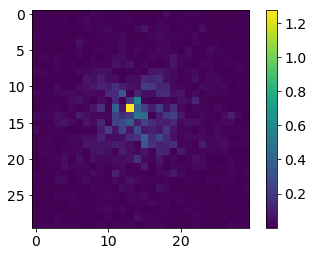

In [0]:
if (ecalDataPojo.response.shape[0] == fakeData.response.shape[0]) :
  plt.imshow(abs(np.mean(ecalDataPojo.response, axis=0, keepdims=False) - np.mean(fakeData.response, axis=0, keepdims=False)))
  plt.colorbar()
  plt.show()

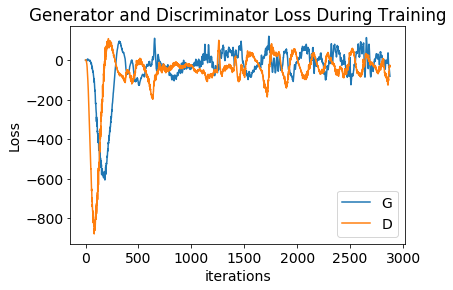

In [0]:
lalalala = 5000
painters.plotLosses(ganTrainer.G_losses[-lalalala:], ganTrainer.D_losses[-lalalala:])

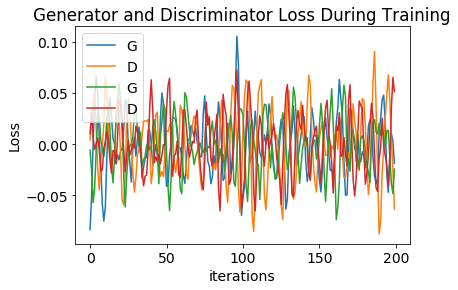

In [0]:
lalalala = 200
painters.plotLosses(ganTrainer.G_losses[-lalalala:], ganTrainer.G_losses[-2*lalalala:-lalalala])
painters.plotLosses(ganTrainer.G_losses[-3*lalalala:-2*lalalala], ganTrainer.G_losses[-4*lalalala:-3*lalalala])


In [29]:
print(netG)
print(netD)

GenEcal(
  (main): Sequential(
    (0): ConvTranspose2d(100, 60, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(60, 30, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(30, 1, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (7): ReLU()
  )
)
DiscEcal(
  (main): Sequential(
    (0): Conv2d(1, 30, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(30, 60, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(60, 10, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)


In [23]:
print(netG)
print(netD)

GenEcal(
  (main): Sequential(
    (0): ConvTranspose2d(100, 60, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(60, 30, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(30, 1, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (7): ReLU()
  )
)
DiscEcal(
  (main): Sequential(
    (0): Conv2d(1, 30, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(30, 60, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(60, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
)


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import mygan

class DiscEcal(nn.Module):
    def __init__(self, type, hyper, problem):
        super(DiscEcal, self).__init__()
        self.ngpu = hyper.ngpu
        self.type = type
        self.size = problem.nc * (problem.imgSize ** 2)
        nf = problem.nz + problem.nf
        nfx2 = nf * 2
        nfx4 = nf * 4
        self.main = nn.Sequential(
             nn.Linear(self.size, nfx4), nn.LeakyReLU(0.2),
             nn.Linear(nfx4, nfx2), nn.LeakyReLU(0.2),
             nn.Linear(nfx2, nf), nn.LeakyReLU(0.2),
             nn.Linear(nf, 1)
        )

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        output = self.main(x)
        if self.type == mygan.GANS.GAN :
            output = F.sigmoid(output)
        return output

class GenEcal(nn.Module):
    def __init__(self, type, hyper, problem):
        super(GenEcal, self).__init__()
        self.nc = problem.nc
        self.imgSize = problem.imgSize
        self.size = problem.nc * (problem.imgSize ** 2)
        nf = problem.nz + problem.nf
        nfx2 = nf * 2
        nfx4 = nf * 4
        self.main = nn.Sequential(
            nn.Linear(problem.nz, nf), nn.ReLU(), nn.BatchNorm1d(nf),
            nn.Linear(nf, nfx2), nn.ReLU(), nn.BatchNorm1d(nfx2),
            nn.Linear(nfx2, nfx4), nn.Tanh(), nn.BatchNorm1d(nfx4),
            # for CramerGan Tanh shown almost same learnability, fastly detecting more modes, need more comparison to ReLU
            nn.Linear(nfx4, self.size),
            nn.ReLU() # ReLU here, because we need 0+ values
        )


    def forward(self, z):
        z = torch.reshape(z, (z.size(0), z.size(1)))
        imgVector = self.main(z)
        return torch.reshape(imgVector, (z.size(0), self.nc, self.imgSize, self.imgSize))